Этот ноутбук --- для реализации функции восстановления сигнала одного из датчиков EEG системы по другим, имеющимся показаниям.

Что будет сделано:

1. Реализованы разные способы восстановления
2. Замерены результаты восстановления
3. на github залит ноутбук с описанием, как этим пользоваться

### Data downloading

In [ ]:
!rm -rf CreationOfIntelligentSystems_Simultaneous_fMRI-EEG/
!git clone -b data https://github.com/intsystems/CreationOfIntelligentSystems_Simultaneous_fMRI-EEG.git
%cd /content/CreationOfIntelligentSystems_Simultaneous_fMRI-EEG/code/data

In [ ]:
!ls

data_labeling.py  data_visualization.ipynb  image_dataset.ipynb   load_natview_subs.py	utils.py
dataset.ipynb	  environment.yml	    load_natview_data.sh  README.md


In [1]:
!mkdir -p /content/CreationOfIntelligentSystems_Simultaneous_fMRI-EEG/code/data/natview/data/

In [2]:
!cp /content/drive/MyDrive/EEG/sub-01.tar.gz /content/CreationOfIntelligentSystems_Simultaneous_fMRI-EEG/code/data/natview/data/sub-01.tar.gz

In [10]:
!mkdir -p natview/data

In [ ]:
file = '/content/CreationOfIntelligentSystems_Simultaneous_fMRI-EEG/code/data/natview/data/sub-01.tar.gz'
!tar -xzvf $file -C ./natview/data

In [4]:
!pip install nilearn -q
!pip install mne -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 76.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 52.0 MB/s eta 0:00:00


### Source code

In [24]:
from nilearn import plotting
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from mne.io import read_raw_eeglab
import mne
from collections import OrderedDict

In [15]:
sub_idx = 1
session_idx = 1

path = f'natview/data/sub-{sub_idx:02d}/ses-{session_idx:02d}/eeg/sub-{sub_idx:02d}_ses-{session_idx:02d}_task-dme_run-01_eeg.set'

raw_data = read_raw_eeglab(path)
data = np.array(raw_data.get_data())
data.shape

<ipython-input-15-356b7636c2fb>:6: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw_data = read_raw_eeglab(path)
<ipython-input-15-356b7636c2fb>:6: RuntimeWarning: Limited 3 annotation(s) that were expanding outside the data range.
  raw_data = read_raw_eeglab(path)
<ipython-input-15-356b7636c2fb>:6: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = read_raw_eeglab(path)


(60, 146875)

In [27]:
import mne
from collections import OrderedDict
from copy import copy

class ChannelRecovering:
    '''
        all methods, used to recover missing eeg channels, based on existing
        important: part of code was apatped from https://github.com/intsystems/CreationOfIntelligentSystems_Simultaneous_fMRI-EEG/blob/data/code/data/dataset.ipynb

        ALL methods are static

        You need methods:

    '''

    all_eeg_channels_ordered = [
            'AF3', 'AF4', 'AF7', 'AF8', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6',
            'CP1', 'CP2', 'CP3', 'CP4', 'CP5', 'CP6', 'CPz', 'Cz', 'F1', 'F2',
            'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'FC1', 'FC2', 'FC3', 'FC4',
            'FC5', 'FC6', 'FT7', 'FT8', 'Fp1', 'Fp2', 'Fpz', 'Fz', 'O1', 'O2',
            'Oz', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'PO3', 'PO4',
            'PO7', 'PO8', 'POz', 'Pz', 'T7', 'T8', 'TP10', 'TP7', 'TP8', 'TP9'
    ]

    EPS = 1e-3

    def __init__(self):
        pass

    ### common method for inserting NaNs for unpresen channels
    @staticmethod
    def insert_nan_rows_in_array(raw_data):
        '''
            adds novel channels into raw_data and fiils it with Nones

            returns:
                - raw_data (np.array) with Nans of shape [n_channels, time]
                - nan_ids (list[int]) with indicies of nan channels (they will be recovered later)

            important: code was apatped from https://github.com/intsystems/CreationOfIntelligentSystems_Simultaneous_fMRI-EEG/blob/data/code/data/dataset.ipynb
        '''

        all_ordered_channels = ChannelRecovering.all_eeg_channels_ordered

        raw_data_ordered = raw_data.reorder_channels(sorted(list(set(all_ordered_channels) & set(raw_data.ch_names))))
        current_channels_ordered = raw_data_ordered.ch_names
        good_indices = []
        i = 0
        j = 0
        while i < len(current_channels_ordered) and j < len(all_ordered_channels):
            if current_channels_ordered[i] == all_ordered_channels[j]:
                good_indices.append(j)
                i += 1
                j += 1
            else:
                j += 1
        raw_data_array = raw_data_ordered.get_data()
        raw_data_array_with_inserted_NaN_rows = np.empty(shape=(len(all_ordered_channels), raw_data_array.shape[1])) # np.zeros((len(all_eeg_channels_ordered), raw_data_array.shape[1]))
        raw_data_array_with_inserted_NaN_rows[:] = np.nan

        for i, idx in enumerate(good_indices):
            raw_data_array_with_inserted_NaN_rows[idx] = raw_data_array[i]


        NaN_ids = np.arange(len(all_ordered_channels))[np.isnan(raw_data_array_with_inserted_NaN_rows).all(axis=1)]

        return raw_data_array_with_inserted_NaN_rows, NaN_ids

    ### 2 functions below for eucludean NN replace
    @staticmethod
    def _find_existing_euclidean_nn(nan_ids, curr_id, all_values):
        '''
            all_values: np.array [n_channels, 3] with spaial coordinates

            find nearest to curr_id channel, that is not contained in nan_ids and != curr_id
        '''

        sq_dists = ((all_values - all_values[curr_id])**2).mean(axis=1) # [n_channels]

        sorted_nearest_ids = np.argsort(sq_dists)

        for near_id in sorted_nearest_ids:
            if near_id not in nan_ids and near_id != curr_id:
                return near_id

        assert False, f"Failed to found nearest existing to {curr_id}. nan_ids: {nan_ids.shape}"

    @staticmethod
    def replace_NaN_with_euclidean_nearest_neighbour(eeg_with_nans, nan_ids):
        eeg_with_nans = eeg_with_nans.copy()
        # Load a standard montage
        montage = mne.channels.make_standard_montage('standard_1020')

        # Get the positions of your channels
        channel_positions = montage.get_positions()['ch_pos']

        ordered = OrderedDict((k, channel_positions[k]) for k in ChannelRecovering.all_eeg_channels_ordered)
        all_values = np.array([ordered[ch_name] for ch_name in ChannelRecovering.all_eeg_channels_ordered])

        replace_ids = []
        for nan_id in nan_ids:
            rep_id = ChannelRecovering._find_existing_euclidean_nn(nan_ids, nan_id, all_values)
            replace_ids.append(rep_id)

        for nan_id, rep_id in zip(nan_ids, replace_ids):
            eeg_with_nans[nan_id] = eeg_with_nans[rep_id]

        return eeg_with_nans

    ### baseline: replace with zeros
    @staticmethod
    def replace_NaN_with_zeros(eeg_with_nans, nan_ids):
        eeg_with_nans = eeg_with_nans.copy()


        # Load a standard montage
        montage = mne.channels.make_standard_montage('standard_1020')

        # Get the positions of your channels
        channel_positions = montage.get_positions()['ch_pos']

        ordered = OrderedDict((k, channel_positions[k]) for k in ChannelRecovering.all_eeg_channels_ordered)
        all_values = np.array([ordered[ch_name] for ch_name in ChannelRecovering.all_eeg_channels_ordered])

        for nan_id in nan_ids:
            eeg_with_nans[nan_id] = 0

        return eeg_with_nans



    ### 2 functions below for advanced kNN replacement
    @staticmethod
    def _find_k_NNs_with_dist_weights_except(k, curr_id, sensors_coordinate, except_lst):

        assert k > 0

        dists = np.sqrt(((sensors_coordinate - sensors_coordinate[curr_id])**2).mean(axis=1)) # [n_channels]

        sorted_nearest_ids = np.argsort(dists)

        found_idx = []
        found_dists = []

        for near_id in sorted_nearest_ids:
            if near_id not in except_lst:
                found_idx.append(near_id)
                found_dists.append(dists[near_id])

                if len(found_idx) == k:
                    return found_idx, found_dists


        assert False, f"Failed to found nearest existing to {curr_id}."


    @staticmethod
    def replace_NaN_with_eucl_weighted_nearest_neighbour(eeg_with_nans, nan_ids, n_neighbours=3):
        eeg_with_nans = eeg_with_nans.copy()
        # Load a standard montage
        montage = mne.channels.make_standard_montage('standard_1020')

        # Get the positions of your channels
        channel_positions = montage.get_positions()['ch_pos']

        ordered = OrderedDict((k, channel_positions[k]) for k in ChannelRecovering.all_eeg_channels_ordered)
        all_values = np.array([ordered[ch_name] for ch_name in ChannelRecovering.all_eeg_channels_ordered])

        replace_into = []
        for nan_id in nan_ids:
            rep_ids, rep_dists = ChannelRecovering._find_k_NNs_with_dist_weights_except(n_neighbours, nan_id, all_values, nan_ids)

            weights = 1 / (np.array(rep_dists) + ChannelRecovering.EPS)[:, None]

            replace_into.append((eeg_with_nans[rep_ids] * weights).sum(axis=0) / weights.sum())

        for nan_id, rep_into in zip(nan_ids, replace_into):
            eeg_with_nans[nan_id] = rep_into

        return eeg_with_nans


In [19]:
def get_eeg_recovered_v1(eeg):
    '''
        reconstructs each row with algo

        algo: eeg, [id] -> reconstructed
    '''

    eeg_new = eeg.copy()

    all_eeg_channels_ordered = [
        'AF3', 'AF4', 'AF7', 'AF8', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6',
        'CP1', 'CP2', 'CP3', 'CP4', 'CP5', 'CP6', 'CPz', 'Cz', 'F1', 'F2',
        'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'FC1', 'FC2', 'FC3', 'FC4',
        'FC5', 'FC6', 'FT7', 'FT8', 'Fp1', 'Fp2', 'Fpz', 'Fz', 'O1', 'O2',
        'Oz', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'PO3', 'PO4',
        'PO7', 'PO8', 'POz', 'Pz', 'T7', 'T8', 'TP10', 'TP7', 'TP8', 'TP9'
    ]

    # Load a standard montage
    montage = mne.channels.make_standard_montage('standard_1020')

    # Get the positions of your channels
    channel_positions = montage.get_positions()['ch_pos']

    ordered = OrderedDict((k, channel_positions[k]) for k in all_eeg_channels_ordered)
    all_values = np.array([ordered[ch_name] for ch_name in all_eeg_channels_ordered])

    nan_ids = np.arange(len(all_eeg_channels_ordered))

    replace_ids = []
    for nan_id in nan_ids:
        rep_id = ChannelRecovering._find_existing_euclidean_nn([], nan_id, all_values)
        replace_ids.append(rep_id)

    for nan_id, rep_id in zip(nan_ids, replace_ids):
        # print(f'{nan_id} <- {rep_id}')
        eeg_new[nan_id] = eeg[rep_id]

    return eeg_new

In [21]:
def get_eeg_recovered_v2(eeg):
    return np.zeros_like(eeg)

In [22]:
EPS = 1e-3

def eeg_recover_v3(eeg, n_neighbours=3):
    new_eeg = eeg.copy()
    all_eeg_channels_ordered = [
        'AF3', 'AF4', 'AF7', 'AF8', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6',
        'CP1', 'CP2', 'CP3', 'CP4', 'CP5', 'CP6', 'CPz', 'Cz', 'F1', 'F2',
        'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'FC1', 'FC2', 'FC3', 'FC4',
        'FC5', 'FC6', 'FT7', 'FT8', 'Fp1', 'Fp2', 'Fpz', 'Fz', 'O1', 'O2',
        'Oz', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'PO3', 'PO4',
        'PO7', 'PO8', 'POz', 'Pz', 'T7', 'T8', 'TP10', 'TP7', 'TP8', 'TP9'
    ]

    # Load a standard montage
    montage = mne.channels.make_standard_montage('standard_1020')

    # Get the positions of your channels
    channel_positions = montage.get_positions()['ch_pos']

    ordered = OrderedDict((k, channel_positions[k]) for k in all_eeg_channels_ordered)
    all_values = np.array([ordered[ch_name] for ch_name in all_eeg_channels_ordered])

    nan_ids = np.arange(len(all_eeg_channels_ordered))

    replace_into = []
    for nan_id in nan_ids:
        rep_ids, rep_dists = ChannelRecovering._find_k_NNs_with_dist_weights_except(n_neighbours, nan_id, all_values, [nan_id])

        weights = 1 / (np.array(rep_dists) + EPS)[:, None]

        replace_into.append((eeg[rep_ids] * weights).sum(axis=0) / weights.sum())

    for nan_id, rep_into in zip(nan_ids, replace_into):
        new_eeg[nan_id] = rep_into

    return new_eeg

#### Будем считать, как хорошо получилось (по MSE и MAE расстоянию).

In [30]:
eeg_with_nan, nan_ids = ChannelRecovering.insert_nan_rows_in_array(raw_data)

# neighbour replacement
eeg_replaced_neighbour = ChannelRecovering.replace_NaN_with_euclidean_nearest_neighbour(eeg_with_nan, nan_ids)
eeg_recovered_neighbour = get_eeg_recovered_v1(eeg_replaced_neighbour)

# zero replacement
eeg_replaced_zero = ChannelRecovering.replace_NaN_with_zeros(eeg_with_nan, nan_ids)
eeg_recovered_zero = get_eeg_recovered_v2(eeg_replaced_zero)

# knn rep =3
eeg_replaced_knn = ChannelRecovering.replace_NaN_with_eucl_weighted_nearest_neighbour(eeg_with_nan, nan_ids, n_neighbours=3)
eeg_recovered_knn = eeg_recover_v3(eeg_replaced_knn, n_neighbours=3)

# knn rep =5
eeg_replaced_knn5 = ChannelRecovering.replace_NaN_with_eucl_weighted_nearest_neighbour(eeg_with_nan, nan_ids, n_neighbours=5)
eeg_recovered_knn5 = eeg_recover_v3(eeg_replaced_knn, n_neighbours=5)

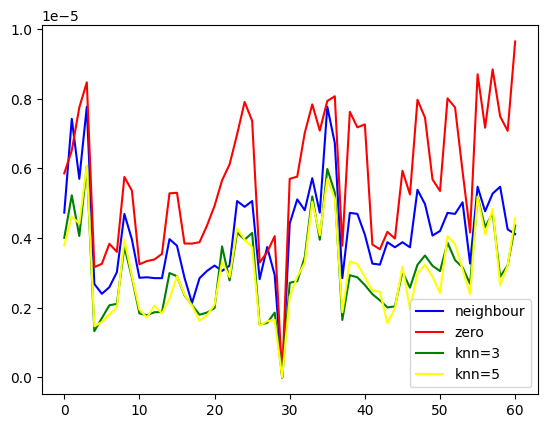

In [33]:
def get_L2_distance(eeg1, eeg2):
    return np.sqrt(((eeg1 - eeg2) ** 2).mean(axis=1))

plt.plot(get_L2_distance(eeg_recovered_neighbour, eeg_replaced_neighbour), label='neighbour', color='blue')
# plt.plot(get_L1_distance(eeg_recovered, eeg_replaced), label='L1', color='red')
plt.plot(get_L2_distance(eeg_recovered_zero, eeg_replaced_zero), label='zero', color='red')
plt.plot(get_L2_distance(eeg_replaced_knn, eeg_recovered_knn), label='knn=3', color='green')
plt.plot(get_L2_distance(eeg_replaced_knn5, eeg_recovered_knn5), label='knn=5', color='yellow')

# plt.plot(get_L2_distance(eeg_replaced_knn3_sphere, eeg_recovered_knn3_sphere), label='knn spher =3', color='black')


plt.legend()